In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict
from sklearn.cluster import KMeans

In [2]:
base_dir = '.'
stimuli_dir = os.path.join(base_dir, "groundtruth")
stimulis = sorted(glob.glob(os.path.join(stimuli_dir, "*")))
stimulis

['./groundtruth/gears_1_annotations.jpg',
 './groundtruth/gears_2_annotations.jpg',
 './groundtruth/levers_1_annotations.jpg',
 './groundtruth/levers_2_annotations.jpg',
 './groundtruth/pulleys_1_annotations.jpg',
 './groundtruth/pulleys_2_annotations.jpg']

In [3]:
imgs = []
for stimuli in stimulis:
    img = cv2.imread(stimuli, cv2.IMREAD_UNCHANGED)
    w, h = img.shape[:2]
    tw, th = max(w, h), max(w, h)
    pad_w, pad_h = (tw - w) // 2, (th - h) // 2
    img = cv2.copyMakeBorder(img, pad_w, pad_w, pad_h, pad_h, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    img = cv2.resize(img, (500, 500), cv2.INTER_NEAREST)
    imgs.append(img)

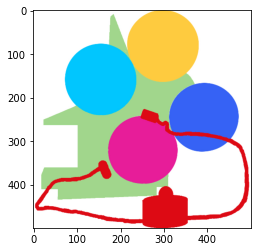

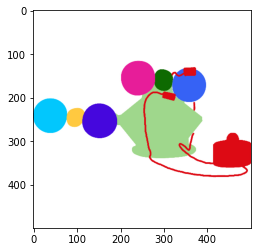

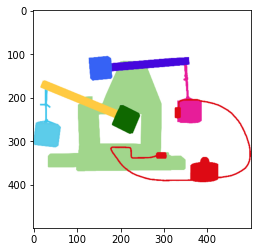

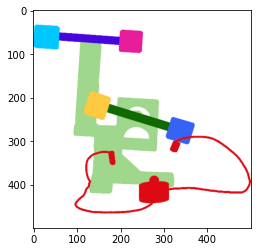

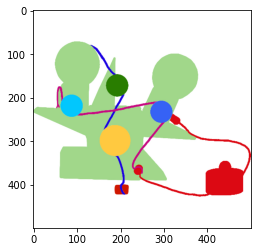

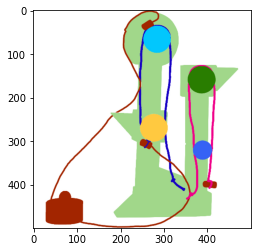

In [4]:
for img in imgs:
    plt.imshow(img)
    plt.show()

In [5]:
def segment(img, n_parts, order=None, exclude=None):
    plt.imshow(img)
    plt.show()
    if order is None or exclude is None:
        raise NotImplementedError
    kmeans = KMeans(n_clusters=n_parts, random_state=0)
    pred = kmeans.fit_predict(img.reshape(-1, 3)).reshape(500, 500)
    
    idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(n_parts)
    pred = lut[pred]
    
    bboxes = OrderedDict()
    for i in range(n_parts):
        mat = np.zeros((500, 500))
        mat[pred == i] = 1
        mat = cv2.morphologyEx(mat, cv2.MORPH_OPEN, np.ones((3, 3)))
        roi = np.where(mat != 0)
        bbox = np.min(roi[1]), np.max(roi[1]), np.min(roi[0]), np.max(roi[0])
        bboxes[float(order[i])] = bbox
    for k in sorted(list(bboxes.keys())):
        if k in exclude:
            bboxes.pop(k)
        else:
            bbox = bboxes[k]
            mat = img.copy()
            mat = cv2.rectangle(mat, (bbox[0], bbox[2]), (bbox[1], bbox[3]), color=(0, 0, 0), thickness=2)
            print(k)
            plt.imshow(mat)
            plt.show()
    return bboxes

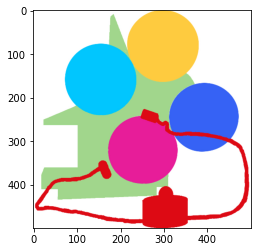

1.0


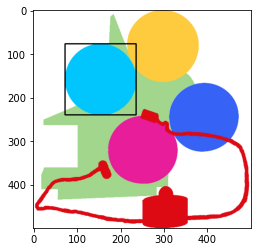

2.0


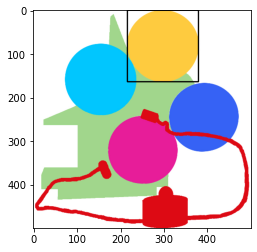

3.0


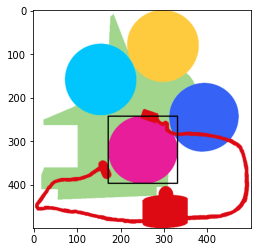

4.0


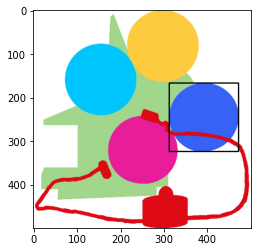

5.0


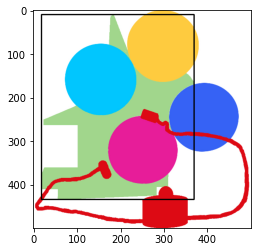

In [6]:
bbox0 = segment(imgs[0], 7, [6, 4, 3, 1, 5, 2, 0], [0, 6])

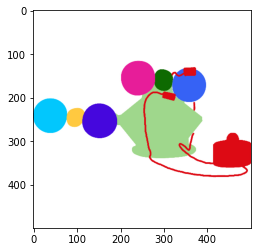

1.0


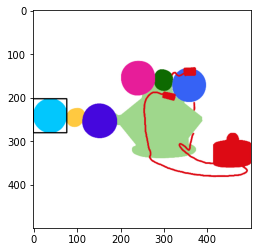

2.0


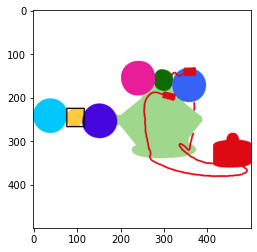

3.0


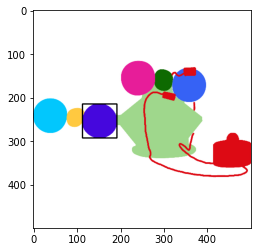

4.0


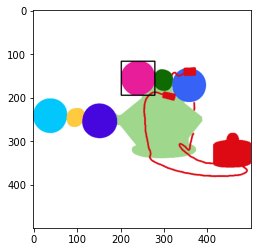

5.0


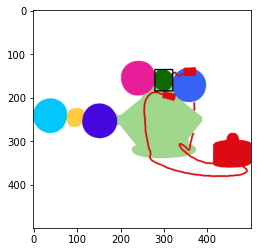

6.0


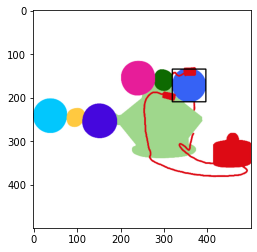

7.0


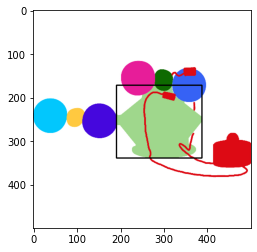

In [7]:
bbox1 = segment(imgs[1], 9, [5, 8, 3, 6, 4, 1, 7, 2, 0], [0, 8])

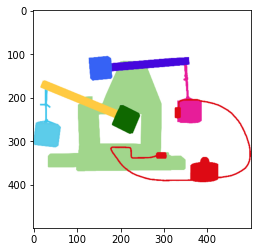

1.0


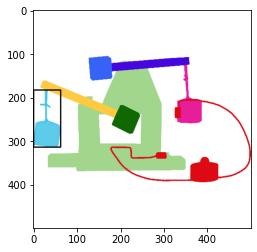

2.0


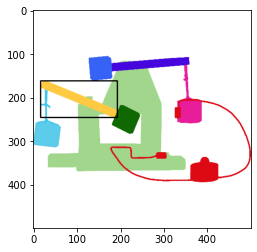

3.0


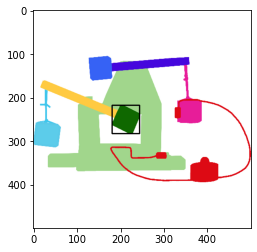

4.0


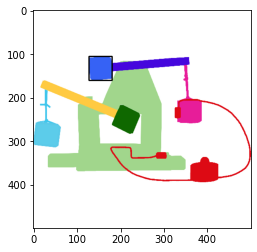

5.0


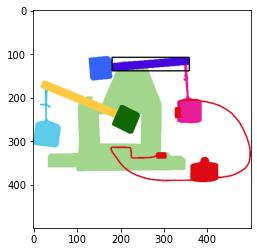

6.0


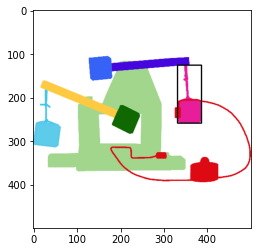

7.0


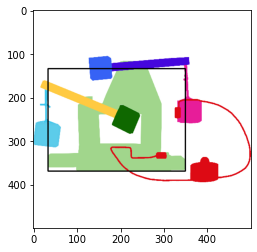

In [8]:
bbox2 = segment(imgs[2], 9, [3, 8, 5, 4, 6, 7, 2, 1, 0], [0, 8])

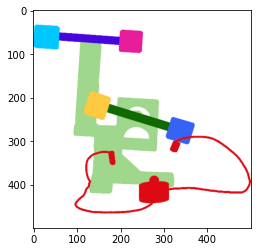

1.0


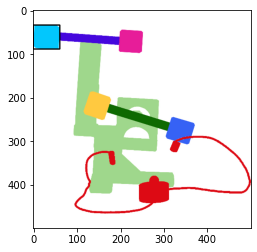

2.0


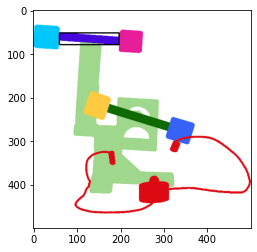

3.0


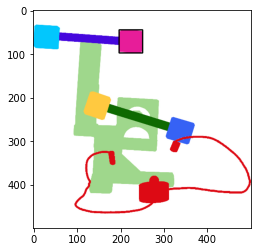

4.0


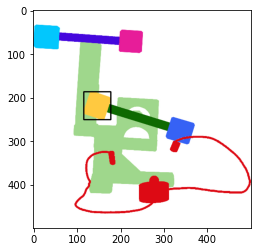

5.0


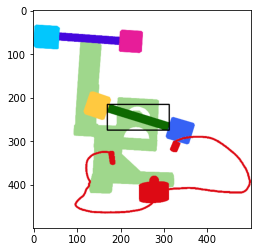

6.0


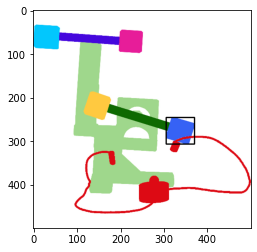

7.0


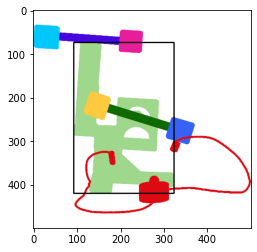

In [9]:
bbox3 = segment(imgs[3], 9, [5, 8, 2, 6, 3, 1, 7, 4, 0], [0, 8])

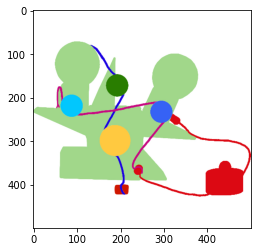

1.0


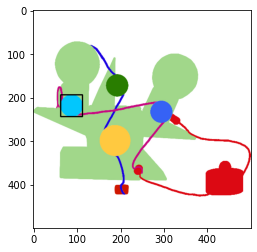

2.0


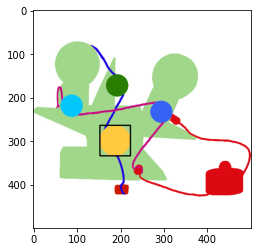

3.0


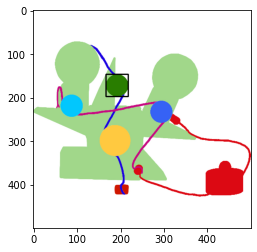

4.0


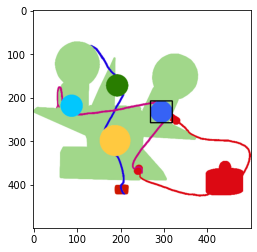

5.0


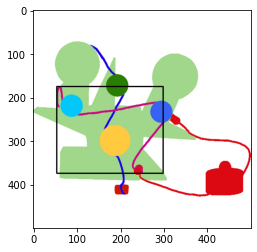

6.0


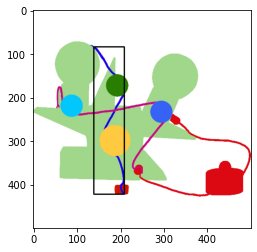

7.0


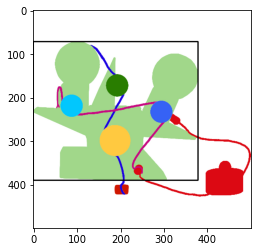

In [10]:
bbox4 = segment(imgs[4], 9, [3, 8, 6, 5, 4, 1, 7, 2, 0], [0, 8])

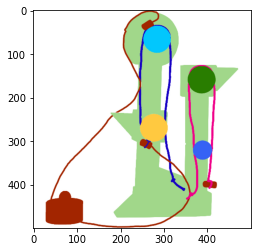

1.0


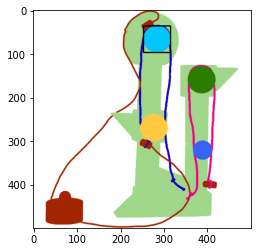

2.0


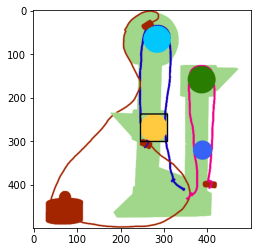

3.0


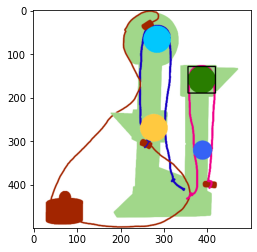

4.0


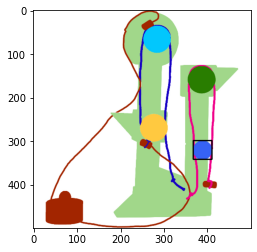

5.0


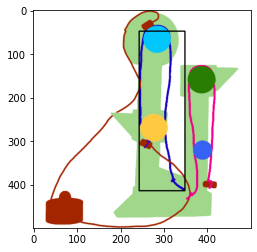

6.0


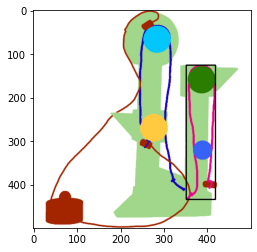

7.0


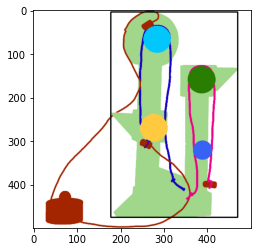

In [11]:
bbox5 = segment(imgs[5], 9, [3, 8, 5, 6, 4, 1, 2, 7, 0], [0, 8])

In [12]:
bbox = {
    "gears_1": bbox0,
    "gears_2": bbox1,
    "levers_1": bbox2,
    "levers_2": bbox3,
    "pulleys_1": bbox4,
    "pulleys_2": bbox5
}

In [13]:
bbox

{'gears_1': OrderedDict([(4.0, (312, 471, 167, 324)),
              (3.0, (172, 331, 243, 397)),
              (1.0, (73, 236, 77, 240)),
              (5.0, (19, 369, 10, 434)),
              (2.0, (216, 379, 0, 164))]),
 'gears_2': OrderedDict([(5.0, (279, 320, 136, 185)),
              (3.0, (113, 192, 215, 293)),
              (6.0, (319, 396, 135, 210)),
              (4.0, (202, 279, 117, 195)),
              (1.0, (0, 77, 203, 281)),
              (7.0, (191, 387, 172, 339)),
              (2.0, (77, 117, 225, 267))]),
 'levers_1': OrderedDict([(3.0, (181, 244, 218, 283)),
              (5.0, (181, 358, 108, 139)),
              (4.0, (128, 181, 106, 161)),
              (6.0, (331, 386, 126, 259)),
              (7.0, (34, 349, 134, 369)),
              (2.0, (17, 193, 162, 246)),
              (1.0, (1, 63, 183, 314))]),
 'levers_2': OrderedDict([(5.0, (170, 312, 216, 275)),
              (2.0, (60, 197, 52, 79)),
              (6.0, (305, 370, 246, 307)),
              (3.0, 

In [14]:
df = pd.DataFrame.from_dict(bbox, orient="index")
df = df.reset_index()
df

,index,4.0,3.0,1.0,5.0,2.0,6.0,7.0
0,gears_1,"(312, 471, 167, 324)","(172, 331, 243, 397)","(73, 236, 77, 240)","(19, 369, 10, 434)","(216, 379, 0, 164)",NaN,NaN
1,gears_2,"(202, 279, 117, 195)","(113, 192, 215, 293)","(0, 77, 203, 281)","(279, 320, 136, 185)","(77, 117, 225, 267)","(319, 396, 135, 210)","(191, 387, 172, 339)"
2,levers_1,"(128, 181, 106, 161)","(181, 244, 218, 283)","(1, 63, 183, 314)","(181, 358, 108, 139)","(17, 193, 162, 246)","(331, 386, 126, 259)","(34, 349, 134, 369)"
3,levers_2,"(116, 178, 187, 251)","(197, 251, 45, 98)","(0, 61, 34, 89)","(170, 312, 216, 275)","(60, 197, 52, 79)","(305, 370, 246, 307)","(93, 323, 74, 420)"
4,pulleys_1,"(269, 319, 208, 258)","(167, 218, 147, 198)","(63, 113, 194, 244)","(54, 298, 175, 374)","(153, 223, 264, 334)","(139, 209, 84, 422)","(0, 378, 72, 390)"
5,pulleys_2,"(367, 410, 299, 342)","(355, 418, 129, 190)","(253, 315, 36, 97)","(243, 348, 48, 414)","(246, 308, 238, 301)","(351, 418, 126, 434)","(178, 469, 4, 475)"


In [15]:
df = df.melt(id_vars="index", var_name="roi", value_name="bbox").sort_values(["index", "roi"]).dropna().reset_index(drop=True)
df = df.rename(columns={"index": "stimuli", "roi": "strokeRoiNum"})
df

,stimuli,strokeRoiNum,bbox
0,gears_1,1.0,"(73, 236, 77, 240)"
1,gears_1,2.0,"(216, 379, 0, 164)"
2,gears_1,3.0,"(172, 331, 243, 397)"
3,gears_1,4.0,"(312, 471, 167, 324)"
4,gears_1,5.0,"(19, 369, 10, 434)"
5,gears_2,1.0,"(0, 77, 203, 281)"
6,gears_2,2.0,"(77, 117, 225, 267)"
7,gears_2,3.0,"(113, 192, 215, 293)"
8,gears_2,4.0,"(202, 279, 117, 195)"
9,gears_2,5.0,"(279, 320, 136, 185)"


In [16]:
df[['stim_x1', 'stim_x2', 'stim_y1', 'stim_y2']] = pd.DataFrame(df['bbox'].tolist(), index=df.index)

In [17]:
df = df.drop(columns="bbox")

In [18]:
base_dir = './../'
csv_dir = os.path.join(base_dir, "results", "csv")
df.to_csv(os.path.join(csv_dir,'causaldraw_annotation_stimulis_bounding_box.csv'))